In [16]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
%matplotlib inline

# 1) Preparing the dataset

In [14]:
# load data
data_source = 'data/realdonaldtrump.csv'
trump_tweets = pd.read_csv(data_source)
column_names = trump_tweets.head(0).columns # column names

In [15]:
print(pd.isnull(trump_tweets).sum()) # empty cells in each column

id               0
link             0
content          0
date             0
retweets         0
favorites        0
mentions     22966
hashtags     37769
dtype: int64


In [19]:
print(trump_tweets.shape) # number of rows and columns

(43352, 8)


In [20]:
print(trump_tweets.dtypes) # column types

id            int64
link         object
content      object
date         object
retweets      int64
favorites     int64
mentions     object
hashtags     object
dtype: object


In [22]:
print(trump_tweets.head()) # first 5 rows

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  
0       510        917      NaN      NaN  
1        34        267      NaN      NaN  

# 2) Visualize dataset

In [26]:
plt.rcParams["figure.figsize"] = (10, 10) 

NameError: name 'y' is not defined

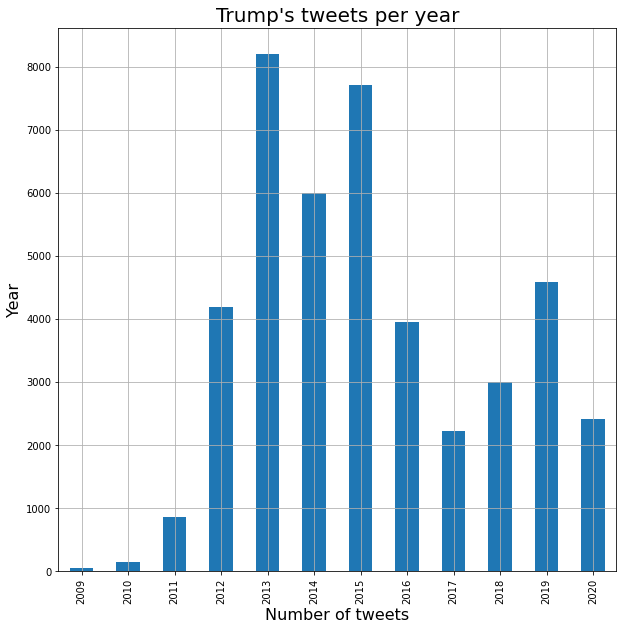

In [43]:
trump_tweets['date'] = trump_tweets['date'].astype('datetime64')
ax = trump_tweets.groupby([trump_tweets['date'].dt.year])['id'].count().plot(kind='bar')

ax.set_title('Trump\'s tweets per year', fontsize=20)
ax.set_xlabel('Number of tweets', fontsize=16)
ax.set_ylabel('Year', fontsize=16)

ax.grid(zorder=0)
ax.bar(range(len(y)), y, width=0.3, align='center', color='skyblue', zorder=3)